### Text Grad CAM using Gluon

The interpretation of the model is more important than the thought from the practical point of view. First, it can be used to confirm that the model is made for common sense. If a model is built on common sense, there is a good chance that it will maintain its stability in operating the model for a long period of time. In addition, there are many cases in which the description of the model score is required in the business, which plays a big role in the understanding and trust of the business. First of all, when the model can be interpreted, there are many cases where new information that was not previously known is known, so the model is used for modeling the reality rather than the purpose of prediction.

The Deep Learning model has been recognized as a representative black box model. However, in view of the author's recent experience, much of the preconceived notion that the deep learning model is a black box model has disappeared. In this article, we try to explain the possibility based on the movie review classification model.

The data used is [Naver sentiment movie corpus](https://github.com/e9t/nsmc), which uses the training set and test set provided in the repository as it is, and a model that predicts the affirmation and negation of the review based on the data provided labels (1: positive, 0: negative) Will be built as a deep learning model.

![Grad CAM image from paper](grad_cam.png)

Although the [Grad CAM paper](https://arxiv.org/abs/1610.02391) based on this article describes images based on the recent trends, Convolution-based techniques are also used for the problems of the text modeling area. I want to try. The Grad CAM scheme is a method of assigning a score to each entry using the backpropagation-based filter weights and convolution output values that cause the model to determine that the review is positive (or negative). For example, if the convolutional output provides a variety of materials that determine something, then the filter weighting is a class-specific, highlighting of the material provided by the convolution. This type of convolution visualization actually uses the gradient ascent technique, but it is a bit easier to understand with the idea of what to maximize. Indeed, in a deep learning study, weighted delta updates of "gradient x -1 x learnig_rate" are done to reduce the loss. Conversely, if we add more delta to the area to be visualized, what we want to see is highlighted. In sum, it is the core of the Grad CAM series to try to interpret the model by reversing the learning process. Here we try to weigh the individual filters of the 1D convolution selected in the model and weigh the results from the filter to see how individual word entries are used to the class to some extent. This allows you to verify that the model is modeled commonsensitively, and can even help you debug the model.

In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import operator
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn

%matplotlib inline

mecab = Mecab()


#### Preprocessing 

In [2]:
tbl = pd.read_csv("ratings_train.txt",sep='\t')

keywords = [mecab.morphs(str(i).strip()) for i in tbl['document']]

np.median([len(k) for k in keywords]), len(keywords), tbl.shape

keyword_cnt = Counter([i for item in keywords for i in item])
#using top  5,000 keywords. 
keyword_clip = sorted(keyword_cnt.items(), key=operator.itemgetter(1))[-5000:]
keyword_clip_dict = dict(keyword_clip)
keyword_dict = dict(zip(keyword_clip_dict.keys(), range(len(keyword_clip_dict))))

#for paddning and unknown keywords  
keyword_dict['_PAD_'] = len(keyword_dict)
keyword_dict['_UNK_'] = len(keyword_dict) 

#Create dictionary to backtrack keywords
keyword_rev_dict = dict([(v,k) for k, v in keyword_dict.items()])

#decide max sequence length
max_seq =np.median([len(k) for k in keywords]) + 5


def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """
    from keras
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x



def encoding_and_padding(corp_list, dic, max_seq=50):
    coding_seq = [ [dic.get(j, dic['_UNK_']) for j in i]  for i in corp_list ]
    #In general, reviews are likely to include a lot of information at the end, so pre-padding is preceded.
    return(pad_sequences(coding_seq, maxlen=max_seq, padding='pre', truncating='pre',value=dic['_PAD_']))


train_x = encoding_and_padding(keywords, keyword_dict, max_seq=int(max_seq))
train_y = tbl['label']
train_x.shape, train_y.shape

((150000, 19), (150000,))

#### Define  DataLoader  

In [67]:
# split train, test 
tr_idx = np.random.choice(train_x.shape[0], int(train_x.shape[0] * 0.9) )
tr_idx_set = set(tr_idx)
te_idx = np.array([i for i in range(train_x.shape[0]) if i not in tr_idx_set])
len(te_idx), len(tr_idx)

tr_set = gluon.data.ArrayDataset(train_x[tr_idx], train_y[tr_idx].as_matrix())
tr_data_iterator = gluon.data.DataLoader(tr_set, batch_size=100, shuffle=True)

te_set =gluon.data.ArrayDataset(train_x[te_idx], train_y[te_idx].as_matrix())
te_data_iterator = gluon.data.DataLoader(te_set, batch_size=100, shuffle=True)

type(train_y), type(train_x)

(pandas.core.series.Series, numpy.ndarray)

#### making model 

In [62]:
class SentClassificationModel(gluon.Block):

    def __init__(self, vocab_size, num_embed, **kwargs):
        super(SentClassificationModel, self).__init__(**kwargs)
        with self.name_scope():
            self.embed = nn.Embedding(input_dim=vocab_size, output_dim=num_embed,
                                        weight_initializer = mx.init.Xavier())
            #if you use Conv2D instead of Conv1D will gain more training performance with cudnn.
            self.conv1 = nn.Conv1D(channels=32, kernel_size=1, padding=1)
            self.conv2 = nn.Conv1D(channels=16, kernel_size=2, padding=1)
            self.conv3 = nn.Conv1D(channels=8, kernel_size=3, padding=2)
            
            self.pool1 = nn.AvgPool1D()
            self.pool2 = nn.AvgPool1D()
            self.pool3 = nn.AvgPool1D()

            self.lstm = rnn.GRU(layout='NTC', hidden_size=10, dropout=0.2, bidirectional=True)
            self.dense = nn.Dense(units=2)
            
            self.conv1_act = None
            
    def forward(self, inputs, get_act=False):
        em_out = self.embed(inputs)
        em_swaped = mx.nd.swapaxes(em_out, 1,2)
        conv1_ = self.conv1(em_swaped)
        if get_act:
            self.conv1_act = conv1_
            
        conv1_out = self.pool1(conv1_)
        conv2_ =self.conv2(em_swaped)
        conv2_out = self.pool2(conv2_)
        conv3_ =self.conv3(em_swaped)
        conv3_out = self.pool3(conv3_)
        cated_layer = mx.nd.concat(conv1_out, conv2_out, conv3_out , dim=1)
        cated_layer = mx.nd.swapaxes(cated_layer, 1,2)
        bigru_out  = self.lstm(cated_layer)
        outs = self.dense(bigru_out)
        return outs

In [68]:
ctx = mx.gpu()

model = SentClassificationModel(vocab_size = len(keyword_dict), num_embed=50)
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'sgd', optimizer_params={'learning_rate':0.01, 'wd':0.00001 })
loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

In [69]:
print(model)

SentClassificationModel(
  (embed): Embedding(5002 -> 50, float32)
  (conv1): Conv1D(None -> 32, kernel_size=(1,), stride=(1,), padding=(1,))
  (conv2): Conv1D(None -> 16, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv3): Conv1D(None -> 8, kernel_size=(3,), stride=(1,), padding=(2,))
  (pool1): AvgPool1D(size=(2,), stride=(2,), padding=(0,), ceil_mode=False)
  (pool2): AvgPool1D(size=(2,), stride=(2,), padding=(0,), ceil_mode=False)
  (pool3): AvgPool1D(size=(2,), stride=(2,), padding=(0,), ceil_mode=False)
  (lstm): GRU(None -> 30, NTC, dropout=0.2, bidirectional)
  (dense): Dense(None -> 2, linear)
)


#### Training 

In [70]:
def calculate_loss(model, data_iter, loss_obj, ctx=ctx):
    test_loss = []
    for i, (te_data, te_label) in enumerate(data_iter):
        te_data = te_data.as_in_context(ctx)
        te_label = te_label.as_in_context(ctx)
        with autograd.predict_mode():
            te_output = model(te_data)
            loss_te = loss_obj(te_output, mx.nd.one_hot(te_label, 2))
        curr_loss = mx.nd.mean(loss_te).asscalar()
        test_loss.append(curr_loss)
    return(np.mean(test_loss))

In [71]:
epochs = 15


tot_test_loss = []
tot_train_loss = []
for e in range(epochs):
    train_loss = []
    #batch training 
    for i, (data, label) in enumerate(tr_data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record(train_mode=False):
            output = model(data)
            loss_ = loss(output, mx.nd.one_hot(label, 2))
            loss_.backward()
        trainer.step(data.shape[0])
        curr_loss = mx.nd.mean(loss_).asscalar()
        train_loss.append(curr_loss)

    #caculate test loss
    test_loss = calculate_loss(model, te_data_iterator, loss_obj = loss, ctx=ctx) 

    print("Epoch %s. Train Loss: %s, Test Loss : %s" % (e, np.mean(train_loss), test_loss))    
    tot_test_loss.append(test_loss)
    tot_train_loss.append(np.mean(train_loss))

Epoch 0. Train Loss: 0.692374, Test Loss : 0.691237
Epoch 1. Train Loss: 0.689511, Test Loss : 0.687366
Epoch 2. Train Loss: 0.68269, Test Loss : 0.675595
Epoch 3. Train Loss: 0.656666, Test Loss : 0.627344
Epoch 4. Train Loss: 0.580514, Test Loss : 0.534484
Epoch 5. Train Loss: 0.508616, Test Loss : 0.478485
Epoch 6. Train Loss: 0.470979, Test Loss : 0.454552
Epoch 7. Train Loss: 0.453337, Test Loss : 0.472394
Epoch 8. Train Loss: 0.440267, Test Loss : 0.438719
Epoch 9. Train Loss: 0.427989, Test Loss : 0.424351
Epoch 10. Train Loss: 0.42147, Test Loss : 0.480444
Epoch 11. Train Loss: 0.41492, Test Loss : 0.42176
Epoch 12. Train Loss: 0.410147, Test Loss : 0.410926
Epoch 13. Train Loss: 0.40522, Test Loss : 0.426308
Epoch 14. Train Loss: 0.40278, Test Loss : 0.438703


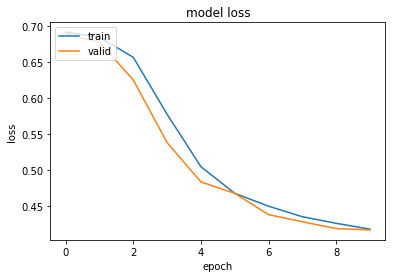

In [22]:
plt.plot(tot_train_loss)
plt.plot(tot_test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Define GRAD CAM function

In [84]:
def grad_cam_conv1D(model, x, loss, ctx):
    with autograd.record():
        output = model.forward(mx.nd.array([x,],ctx=ctx),get_act=True)
        loss_ = loss(output, mx.nd.array([[0.0,1.0],],ctx=ctx))
        output = mx.nd.SoftmaxActivation(output)
        print(output)
        loss_.backward()
    acts = model.conv1_act
    pooled_grad = mx.nd.mean(model.conv1.weight.grad(), axis=(1,2))
    for i in range(acts.shape[1]):
        acts[:,i,:] *= pooled_grad[i]
    heat = mx.nd.mean(acts, axis=1)
    return(heat.asnumpy()[0][1:-1], loss_)


In [51]:
#making test set 
tbl_test = pd.read_csv("ratings_test.txt",sep='\t')
parsed_text = [mecab.morphs(str(i).strip()) for i in tbl_test['document']]
test_x = encoding_and_padding(parsed_text, keyword_dict, max_seq=int(max_seq))
test_y = tbl_test['label']


In [26]:
prob = model(mx.nd.array(test_x, ctx=ctx))

In [27]:
prob_np = mx.nd.SoftmaxActivation(prob).asnumpy()

In [28]:
prob_np_a = prob_np[:,1]

In [29]:
%reload_ext rpy2.ipython

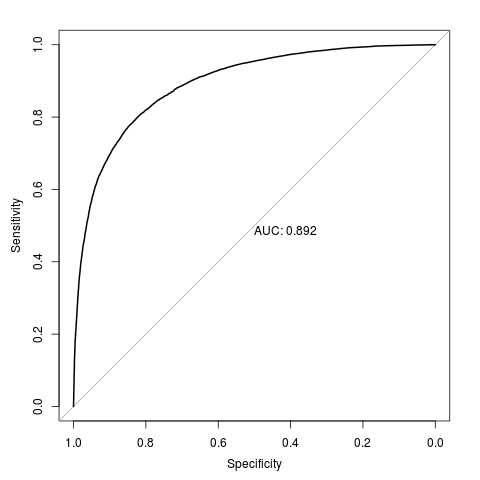

In [31]:
%%R -i test_y -i prob_np_a
#roc tells it's quite good performance
require(pROC)
plot(roc(test_y, prob_np_a), print.auc=TRUE)

In [108]:
idx = 100

In [113]:
# below revew means "Only a few masterpieces are full of rubbish." with negative feedback.
prob_np[idx], tbl_test.iloc[idx], test_y[idx]

(array([ 0.92511469,  0.07488529], dtype=float32),
 id                      1449086
 document    걸작은 몇안되고 졸작들만 넘쳐난다.
 label                         0
 Name: 100, dtype: object,
 0)

In [110]:
heat, loss__ = grad_cam_conv1D(model, test_x[idx], loss=loss, ctx=ctx)


[[ 0.86101919  0.13898079]]
<NDArray 1x2 @gpu(0)>


In [111]:
hm_tbl = pd.DataFrame({'heat':heat, 'kw':[keyword_rev_dict[i] for i in test_x[idx] ]})

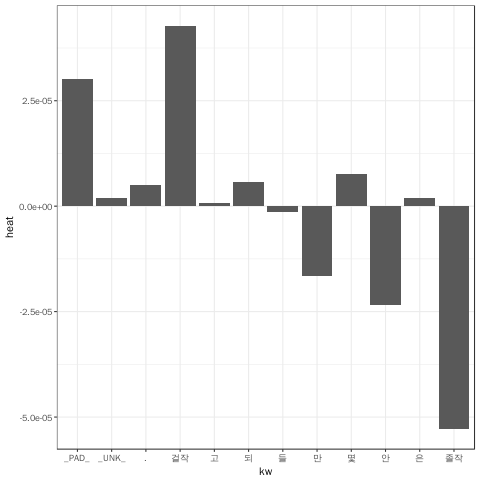

In [112]:
%%R -i hm_tbl
library(ggplot2)
library(extrafont)

ggplot(hm_tbl, aes(x=kw, y=heat)) + geom_bar(stat='identity') + theme_bw(base_family = 'UnDotum') 

Considering affirmation, the word "masterpiece(걸작)" contributed to the positive evaluation, and the word "rubbish(졸작)" contributed the opposite.